In [1]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

import json

import matplotlib.pyplot as plt

In [2]:
# Use dask to read in the csv file as a dataframe
listings_df = dd.read_csv("Resources/listings.csv", assume_missing = True)

In [3]:
# Select only the columns we want for our analysis
listings_df = listings_df[["id", "neighbourhood", "latitude", "longitude", "room_type", "price", "availability_365", "calculated_host_listings_count"]].copy()
listings_df.head()

,id,neighbourhood,latitude,longitude,room_type,price,availability_365,calculated_host_listings_count
0,360.0,Highland,39.766415,-105.002098,Entire home/apt,91.0,179.0,2.0
1,364.0,Five Points,39.766720,-104.979060,Entire home/apt,179.0,358.0,1.0
2,590.0,North Park Hill,39.755110,-104.911090,Private room,59.0,146.0,2.0
3,592.0,North Park Hill,39.754810,-104.911060,Private room,58.0,210.0,2.0
4,1940.0,Baker,39.720205,-104.997499,Entire home/apt,77.0,243.0,1.0


In [4]:
# Find datatypes for each column
print(listings_df.dtypes)

id                                        float64
neighbourhood                     string[pyarrow]
latitude                                  float64
longitude                                 float64
room_type                         string[pyarrow]
price                                     float64
availability_365                          float64
calculated_host_listings_count            float64
dtype: object


In [5]:
# Change datatypes
listings_df["id"] = listings_df["id"].astype(int)
listings_df["availability_365"] = listings_df["availability_365"].astype(int)
listings_df["calculated_host_listings_count"] = listings_df["calculated_host_listings_count"].astype(int)

# Rename columns
listings_df = listings_df.rename(columns={
    "id": "ID",
    "neighbourhood": "Neighborhood",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "room_type": "Listing Type",
    "price": "Price",
    "availability_365": "Available Days per Year",
    "calculated_host_listings_count": "Host Listings Count"
})

In [6]:
# Check datatypes were successfully changed
print(listings_df.dtypes)

ID                                   int32
Neighborhood               string[pyarrow]
Latitude                           float64
Longitude                          float64
Listing Type               string[pyarrow]
Price                              float64
Available Days per Year              int32
Host Listings Count                  int32
dtype: object


In [7]:
# Find out if there are null values in each column
print(listings_df.isnull().sum().compute())

ID                           0
Neighborhood                 0
Latitude                     0
Longitude                    0
Listing Type                 0
Price                      573
Available Days per Year      0
Host Listings Count          0
dtype: int64


In [8]:
# Remove all rows with null values
listings_df = listings_df.dropna()

In [9]:
# Recheck for null values
print(listings_df.isnull().sum().compute())

ID                         0
Neighborhood               0
Latitude                   0
Longitude                  0
Listing Type               0
Price                      0
Available Days per Year    0
Host Listings Count        0
dtype: int64


In [10]:
# Get statistical information
summary_stats = listings_df[["Latitude", "Longitude", "Price", "Available Days per Year"]].describe()
print(summary_stats.compute())

          Latitude    Longitude        Price  Available Days per Year
count  4578.000000  4578.000000  4578.000000              4578.000000
mean     39.742149  -104.975373   162.639144               219.004806
std       0.031772     0.061382   239.225490               116.491189
min      39.625750  -105.102804    10.000000                 0.000000
25%      39.728498  -105.016473    84.000000               116.000000
50%      39.748135  -104.984050   117.000000               237.000000
75%      39.762350  -104.957370   178.000000               334.000000
max      39.847417  -104.673817  9999.000000               365.000000


In [11]:
# Find out how many listings have "Available Days per Year" as 0
print(listings_df.query("`Available Days per Year` == 0").count().compute())

ID                         77
Neighborhood               77
Latitude                   77
Longitude                  77
Listing Type               77
Price                      77
Available Days per Year    77
Host Listings Count        77
dtype: int64


In [12]:
# Filter out all rows where "Available Days per Year" is 0
listings_df = listings_df.query("`Available Days per Year` ! = 0")

In [13]:
# Look at statistical information again after filtering out rows
summary_stats = listings_df[["Latitude", "Longitude", "Price", "Available Days per Year"]].describe()
print(summary_stats.compute())

          Latitude    Longitude        Price  Available Days per Year
count  4501.000000  4501.000000  4501.000000              4501.000000
mean     39.742191  -104.975155   162.798267               222.751389
std       0.031843     0.061594   240.860574               113.875617
min      39.625750  -105.102804    10.000000                 1.000000
25%      39.728490  -105.016480    84.000000               121.000000
50%      39.748120  -104.983920   116.000000               240.000000
75%      39.762540  -104.956978   178.000000               335.000000
max      39.847417  -104.673817  9999.000000               365.000000


In [14]:
listings_df_cleaned = listings_df.copy()
listings_df_cleaned.head()

,ID,Neighborhood,Latitude,Longitude,Listing Type,Price,Available Days per Year,Host Listings Count
0,360,Highland,39.766415,-105.002098,Entire home/apt,91.0,179,2
1,364,Five Points,39.766720,-104.979060,Entire home/apt,179.0,358,1
2,590,North Park Hill,39.755110,-104.911090,Private room,59.0,146,2
3,592,North Park Hill,39.754810,-104.911060,Private room,58.0,210,2
4,1940,Baker,39.720205,-104.997499,Entire home/apt,77.0,243,1


In [15]:
# Export cleaned data to a new csv
listings_df_cleaned.to_csv('Resources/cleaned_listings.csv', index=False, single_file=True)

['c:\\Repos\\Project-5_Group-3\\Resources\\cleaned_listings.csv']

In [16]:
# Convert cleaned_listings.csv into a .json file 
listings_df = dd.read_csv('Resources/cleaned_listings.csv')

# Compute the DataFrame to Pandas (if the dataset fits into memory)
listings_pandas_df = listings_df.compute()

# Convert to list of dictionaries (this is how the data will be represented in JavaScript)
data_as_dict = listings_pandas_df.to_dict(orient='records')

# Write the JavaScript data to a .json file
with open("Resources/listings.json", "w") as json_file:
    json.dump(data_as_dict, json_file, indent=4)

In [17]:
# Convert price and availability_365 to int
listings_df_cleaned["Price"] = pd.to_numeric(listings_df_cleaned["Price"], errors="coerce")
listings_df_cleaned["Available Days per Year"] = pd.to_numeric(listings_df_cleaned["Available Days per Year"], errors="coerce")
# Multiply price * available days per year
listings_df_cleaned["potential_revenue"] = listings_df_cleaned["Price"] * listings_df_cleaned["Available Days per Year"]
# If llisting is at 70% occupancy
listings_df_cleaned["potential_revenue_70"] = listings_df_cleaned["Price"] * listings_df_cleaned["Available Days per Year"] * 0.7
# If llisting is at 50% occupancy
listings_df_cleaned["potential_revenue_50"] = listings_df_cleaned["Price"] * listings_df_cleaned["Available Days per Year"] * 0.5


listings_df_cleaned.head()


,ID,Neighborhood,Latitude,Longitude,Listing Type,Price,Available Days per Year,Host Listings Count,potential_revenue,potential_revenue_70,potential_revenue_50
0,360,Highland,39.766415,-105.002098,Entire home/apt,91.0,179,2,16289.0,11402.3,8144.5
1,364,Five Points,39.766720,-104.979060,Entire home/apt,179.0,358,1,64082.0,44857.4,32041.0
2,590,North Park Hill,39.755110,-104.911090,Private room,59.0,146,2,8614.0,6029.8,4307.0
3,592,North Park Hill,39.754810,-104.911060,Private room,58.0,210,2,12180.0,8526.0,6090.0
4,1940,Baker,39.720205,-104.997499,Entire home/apt,77.0,243,1,18711.0,13097.7,9355.5


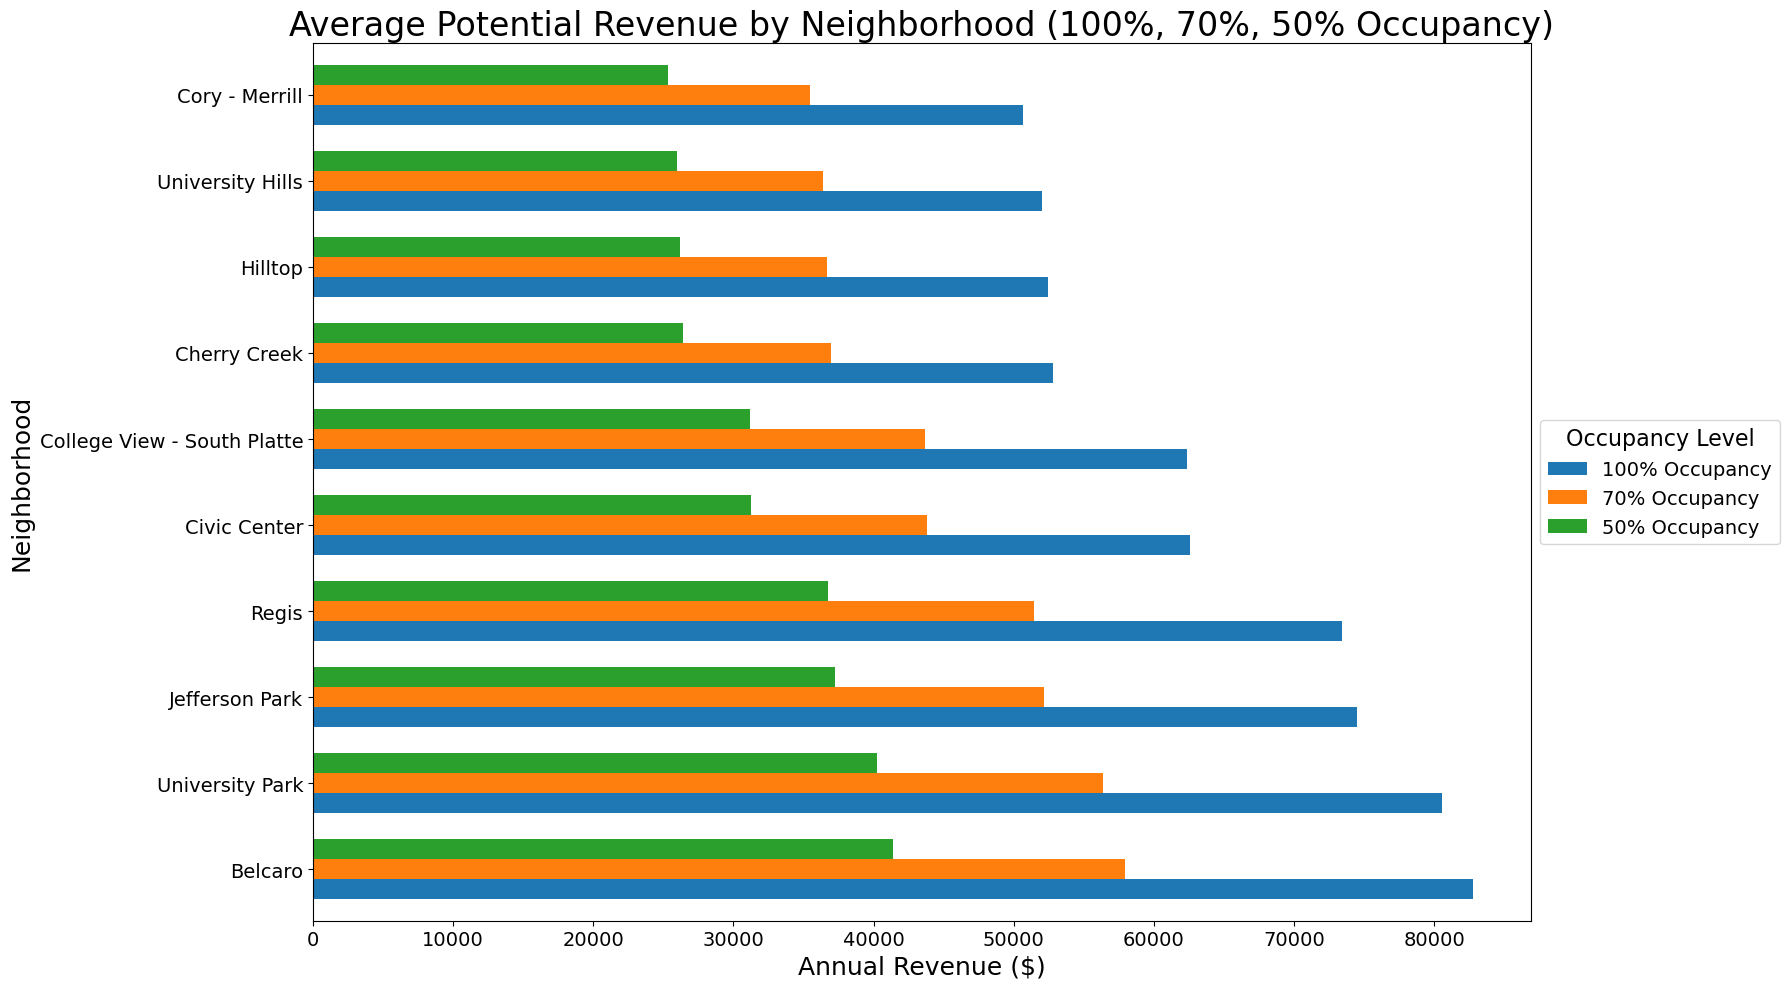

In [18]:
# Convert from Dask
listings_df_cleaned_pd = listings_df_cleaned.compute()

# Group & sort
grouped = listings_df_cleaned_pd.groupby("Neighborhood")[["potential_revenue", "potential_revenue_70", "potential_revenue_50"]].mean()
grouped = grouped.sort_values("potential_revenue", ascending=False).head(10)

# Rename legend
grouped = grouped.rename(columns={
    "potential_revenue": "100% Occupancy",
    "potential_revenue_70": "70% Occupancy",
    "potential_revenue_50": "50% Occupancy"
})

# Plot
fig, ax = plt.subplots(figsize=(18, 10))
grouped.plot(kind='barh', width=0.7, ax=ax)

# Labels and formatting
ax.set_title("Average Potential Revenue by Neighborhood (100%, 70%, 50% Occupancy)", fontsize=24)
ax.set_xlabel("Annual Revenue ($)", fontsize=18)
ax.set_ylabel("Neighborhood", fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Legend outside chart
ax.legend(title="Occupancy Level", fontsize=14, title_fontsize=16, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

In [19]:
# Part 2 real estate prices based on zillow

In [20]:
# Use dask to read in the csv file as a dataframe
zillow_df = dd.read_csv("Resources/cleaned_denver_real_estate.csv", assume_missing = True)

In [21]:
# Select only the columns we want for our analysis
zillow_df = zillow_df[["RegionID", "Neighborhood", "Average Home Price 2024"]].copy()
zillow_df.head()

,RegionID,Neighborhood,Average Home Price 2024
0,273809.0,Gateway - Green Valley Ranch,489603.54
1,6018.0,Montbello,438895.80
2,275564.0,Central Park,805134.55
3,268671.0,Hampden,523696.84
4,268662.0,Five Points,612445.71


In [22]:
# Find datatypes for each column
print(zillow_df.dtypes)

RegionID                           float64
Neighborhood               string[pyarrow]
Average Home Price 2024            float64
dtype: object


In [23]:
# Find out if there are null values in each column
print(zillow_df.isnull().sum().compute())

RegionID                   0
Neighborhood               0
Average Home Price 2024    0
dtype: int64


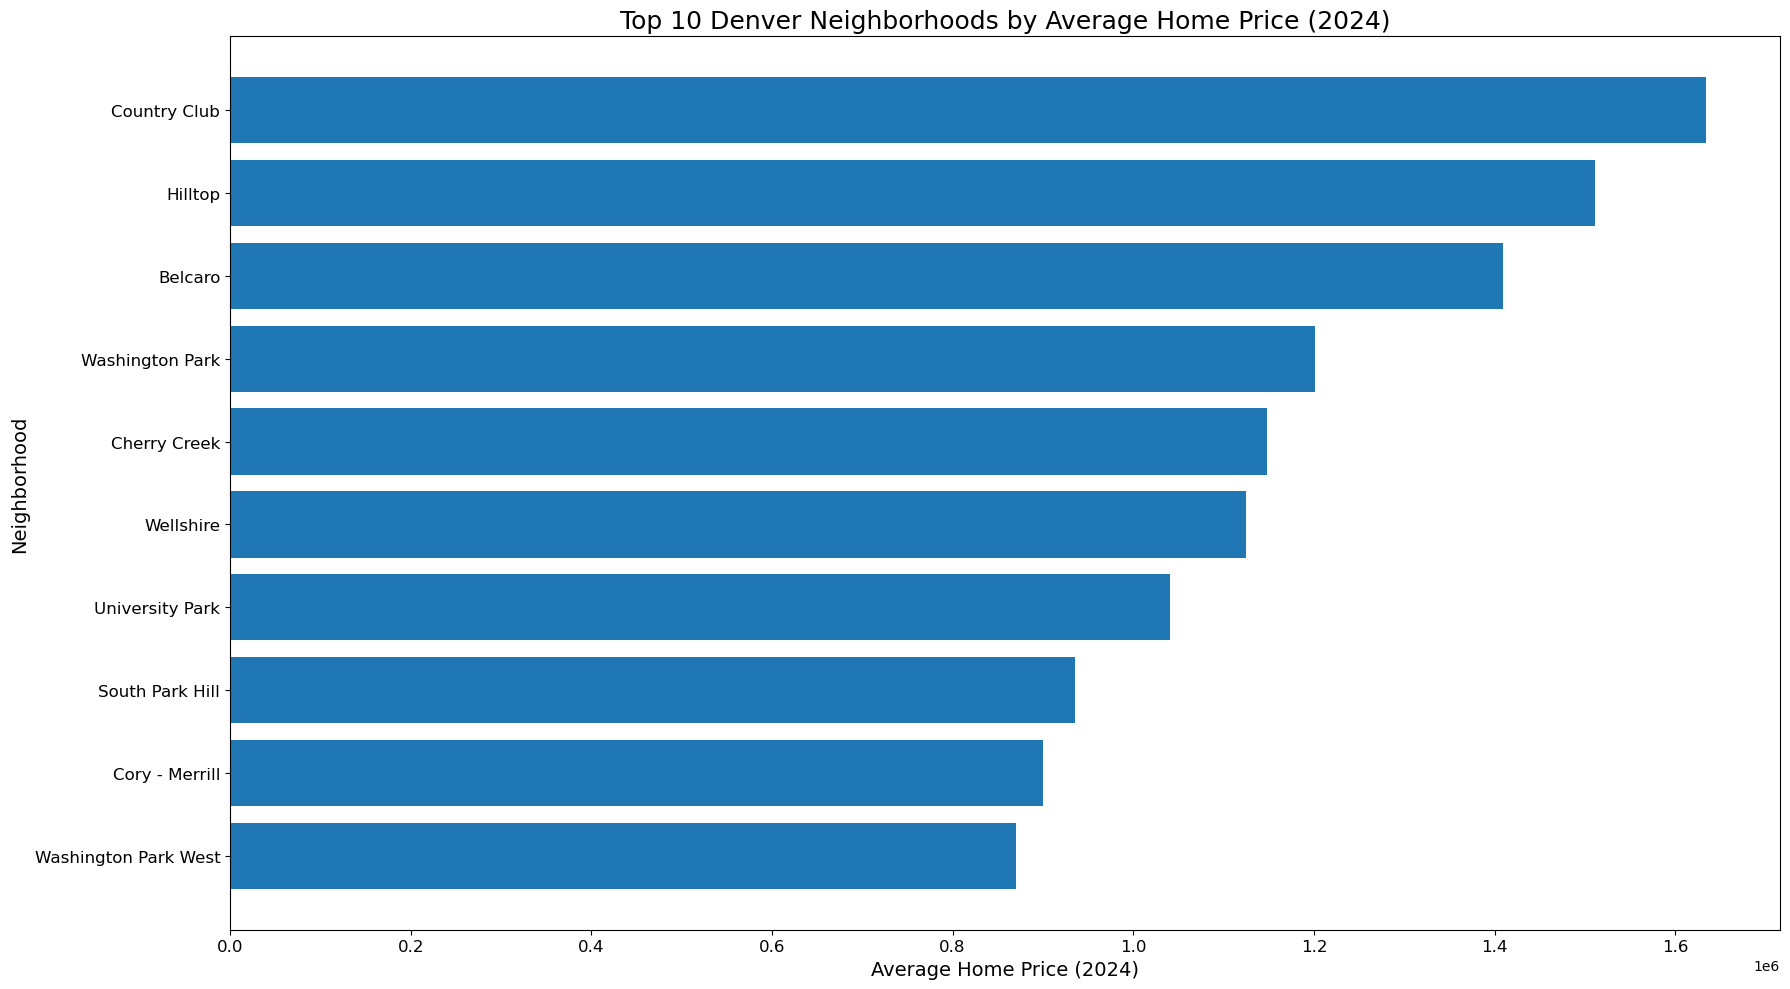

In [24]:
# Convert from Dask
zillow_df_pd = zillow_df.compute()

# Sort by home price and pick top 20 for readability
zillow_sorted = zillow_df.sort_values("Average Home Price 2024", ascending=False).head(10)
                                                                                    
# Plot
plt.figure(figsize=(18, 10))
plt.barh(zillow_sorted["Neighborhood"], zillow_sorted["Average Home Price 2024"])
plt.xlabel("Average Home Price (2024)", fontsize=14)
plt.ylabel("Neighborhood", fontsize=14)
plt.title("Top 10 Denver Neighborhoods by Average Home Price (2024)", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Highest price at top
plt.tight_layout()
plt.show()




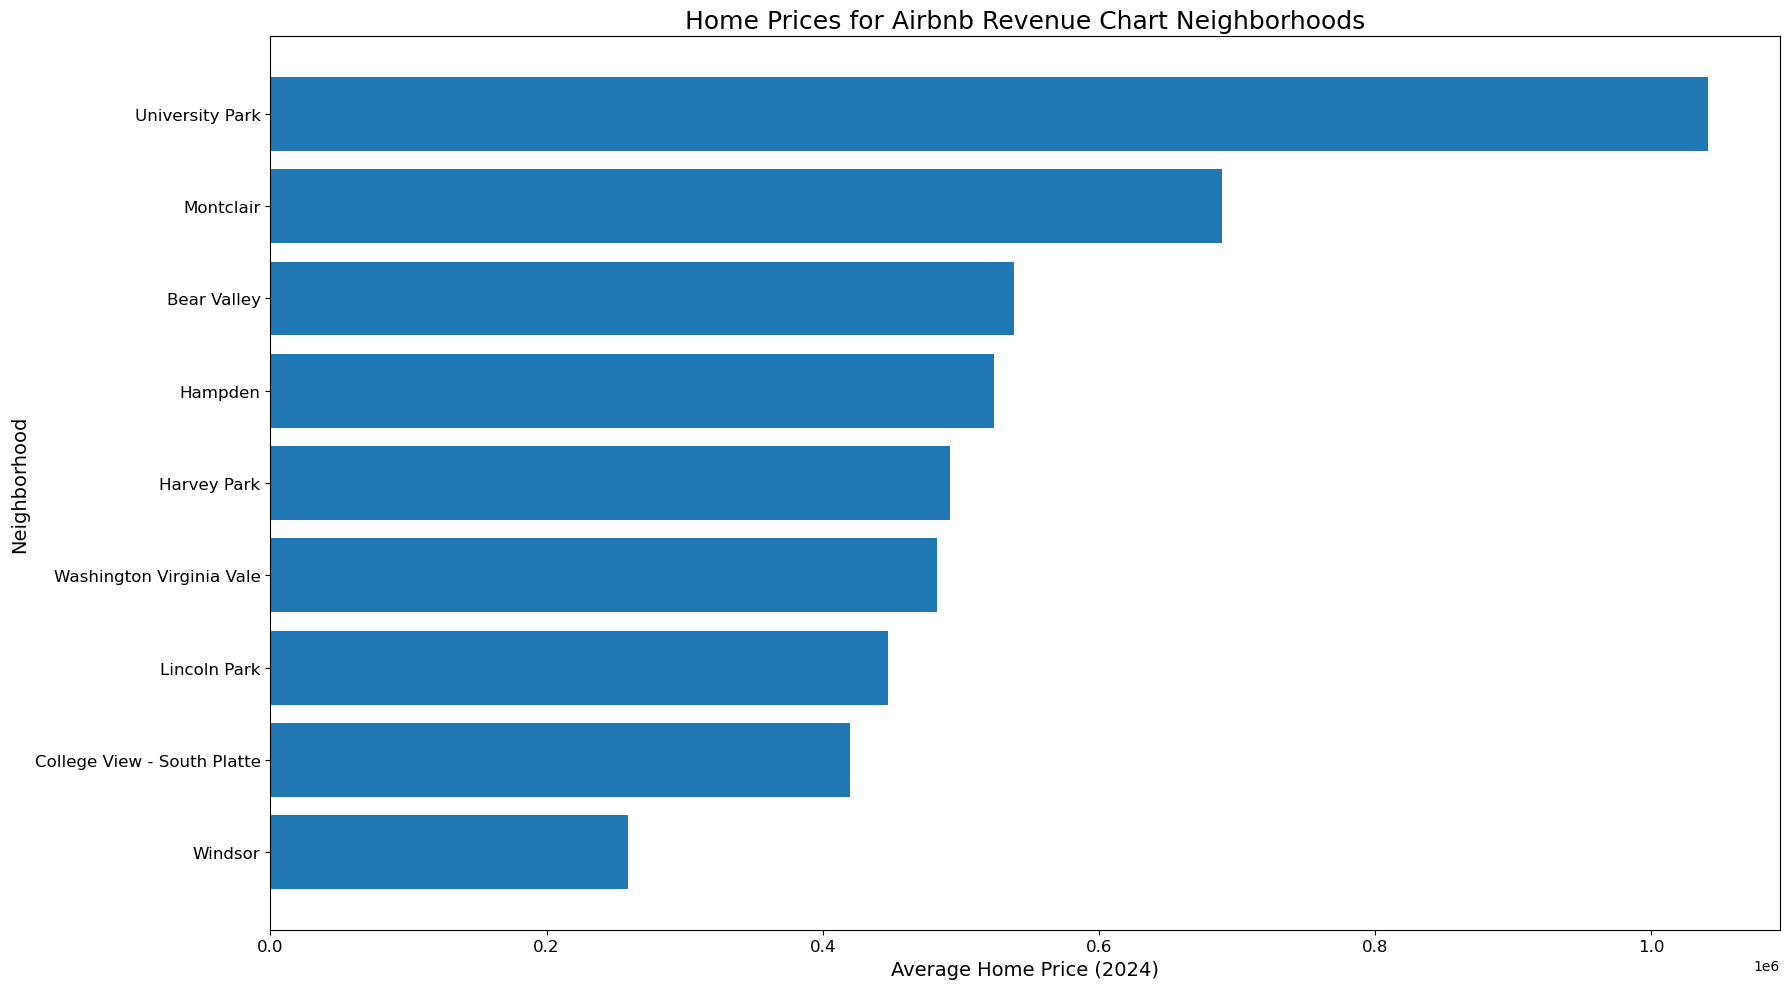

In [33]:
# Filter Airbnb neighborhoods in the chart image by top revenue 
top_airbnb_chart_neighborhoods = [
    "CBD", "Hampden", "College View - South Platte", "Bear Valley", "Harvey Park",
    "University Park", "Washington Virginia Vale", "Lincoln Park", "Montclair", "Windsor"
]

# Filter Zillow data to match these neighborhoods
zillow_matched = zillow_df[zillow_df["Neighborhood"].isin(top_airbnb_chart_neighborhoods)]

# Sort by home price for clean plotting
zillow_matched_sorted = zillow_matched.sort_values("Average Home Price 2024", ascending=False)

# Plot
plt.figure(figsize=(18, 10))
plt.barh(zillow_matched_sorted["Neighborhood"], zillow_matched_sorted["Average Home Price 2024"])
plt.xlabel("Average Home Price (2024)", fontsize=14)
plt.ylabel("Neighborhood", fontsize=14)
plt.title("Home Prices for Airbnb Revenue Chart Neighborhoods", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [29]:
print(zillow_df.head())


   RegionID                  Neighborhood  Average Home Price 2024
0  273809.0  Gateway - Green Valley Ranch                489603.54
1    6018.0                     Montbello                438895.80
2  275564.0                  Central Park                805134.55
3  268671.0                       Hampden                523696.84
4  268662.0                   Five Points                612445.71


In [51]:
# Strip whitespace from all column names (if you haven't already)
zillow_df.columns = zillow_df.columns.str.strip()

# Recalculate 70% occupancy revenue for Airbnb listings
listings_df_cleaned["potential_revenue"] = listings_df_cleaned["Price"] * listings_df_cleaned["Available Days per Year"]
listings_df_cleaned["potential_revenue_70"] = listings_df_cleaned["potential_revenue"] * 0.7

# Group by neighborhood to get average potential revenue at 70% occupancy
airbnb_grouped = listings_df_cleaned.groupby("Neighborhood")["potential_revenue_70"].mean().reset_index()

# Define target neighborhoods
target_neighborhoods = [
    "CBD", "Hampden", "College View - South Platte", "Bear Valley", "Harvey Park",
    "University Park", "Washington Virginia Vale", "Lincoln Park", "Montclair", "Windsor"
]

# Filter both datasets to matching neighborhoods using pandas
airbnb_filtered_df = airbnb_grouped[airbnb_grouped["Neighborhood"].isin(target_neighborhoods)]
zillow_filtered_df = zillow_df[zillow_df["Neighborhood"].isin(target_neighborhoods)]

# Merge the data (Airbnb revenue + Zillow home prices)
combined_df = pd.merge(
    airbnb_filtered_df,
    zillow_filtered_df[["Neighborhood", "Average Home Price 2024"]],
    on="Neighborhood"
)

# Sort by potential Airbnb revenue (70% occupancy)
combined_df = combined_df.sort_values("potential_revenue_70", ascending=False)

# Display the result
combined_df


TypeError: Can only merge Series or DataFrame objects, a <class 'dask_expr._collection.DataFrame'> was passed

In [ ]:
x = np.arange(len(combined_df))
width = 0.35

fig, ax = plt.subplots(figsize=(18, 10))

bar1 = ax.bar(x - width/2, combined_df["potential_revenue_70"], width, label="Airbnb Revenue (70%)")
bar2 = ax.bar(x + width/2, combined_df["Average Home Price 2024"], width, label="Home Price 2024")

ax.set_xlabel("Neighborhood", fontsize=14)
ax.set_ylabel("Amount ($)", fontsize=14)
ax.set_title("Airbnb Revenue (70% Occ.) vs. Home Price by Neighborhood", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(combined_df["Neighborhood"], rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()